In [31]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

from algorithm import *
from entity import *
from utils import deg_pol2cart, analysis

## 仿真实验


### 声场仿真

几何模型:
- 以三元阵中心为原点, 其中阵元1在x轴负半轴
- 声源S角度为角度制下极坐标角度

运动模型:
- 声源S静止
- 三元阵以相对于三元阵初始坐标轴的速度运动

In [32]:
sample_interval = 1  # 采样时长
fs = 500e3  # 采样频率500k
vel_angle = 90
speed = 1
velocity = deg_pol2cart(speed, vel_angle)

target_sig = CW_Signal(
    f=75000,  # 声源频率
    T=1,  # Cw信号周期
    T_on=10e-3,  # Cw信号脉宽
)
sig = Array_Signals(
    CW_Source(
    signal=target_sig,
    r=1000,  # 声源距离
    angle=70  # 声源角度
),
    Three_Elements_Array(d=1, K=1),
    c=1500  # 声速
)

# sig.array.set_noise_params(0.01, 0.01, 0.01)
# sig.set_ideal()
sig.init_rng(0)

#### 生成各阵元电信号AD采样后信号

In [33]:
t = np.arange(0, sample_interval, 1 / fs)
%time x = sig.next(t, velocity)

CPU times: user 974 ms, sys: 2.22 ms, total: 977 ms
Wall time: 75.9 ms


##### 信号图像

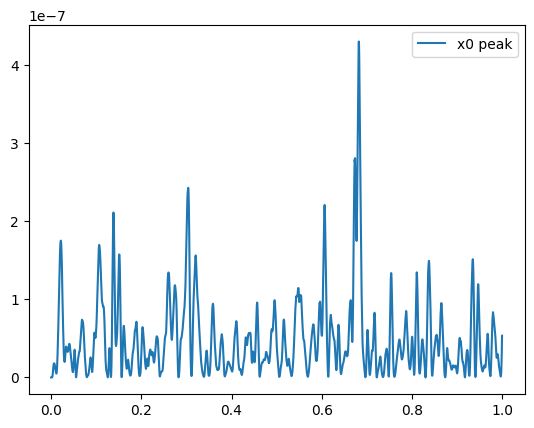

In [34]:
# %matplotlib qt

sos = signal.butter(3, (target_sig.f - 50, target_sig.f + 50), 'bandpass', fs=fs, output='sos')
pow_num = 2
x_filtered = [signal.sosfilt(sos, x_i)**pow_num for x_i in x]
peaks = [signal.find_peaks(x_i, height=0, distance=8)[0] for x_i in x_filtered]

i = 0
# plt.plot(t, x[i], label=f'x{i}')
# plt.plot(t, x_filtered[i], label=f'x{i} filtered')
plt.plot(t[peaks[i]], x_filtered[i][peaks[i]], label=f'x{i} peak')
plt.legend()
plt.show()

### 定位

#### 时延估计

In [35]:
sos = signal.butter(3, (target_sig.f - 50, target_sig.f + 50), 'bandpass', fs=fs, output='sos')
pow_num = 2
x = np.array([signal.sosfilt(sos, x_i)**pow_num for x_i in x])
tau12_hat = time_delay_estimation(x[0], x[1], target_sig.f, fs, 'xcorr')
tau23_hat = time_delay_estimation(x[1], x[2], target_sig.f, fs, 'xcorr')

In [36]:
%%time
# x1, x2, x3 = x
# # FIXME: 不知道CW初相位
# tau12_hat = cw_delay_estimation(x1, x2, fs, target_sig, 1)
# tau23_hat = cw_delay_estimation(x2, x3, fs, target_sig, 1)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.63 µs


#### 解算方位

In [37]:
# TODO: 怎么判别待定
choice = None

tau_hat = np.array([tau12_hat, tau23_hat])
valid = np.abs(tau_hat) < sig.array.d * np.array([1, sig.array.K]) / sig.c

if np.sum(valid) == 2:
    # 都有效
    if np.sign(tau12_hat) != np.sign(tau23_hat):
        choice = 2  # 90度
    else:
        choice = 0 if abs(tau12_hat) < abs(tau23_hat) else 1  # 选绝对值小的
elif np.sum(valid) == 1:
    choice = np.where(valid)[0][0]  # 用有效的那个
# else是都无效, 弃用当前数据

In [38]:
r_far, angle_far = far_locate(tau12_hat, tau23_hat, sig.c, sig.array.K, sig.array.d)
# r_near, angle_near = near_locate(tau12_hat, tau23_hat, sig.c, sig.K, sig.d)

In [39]:
analysis(sig, tau12_hat, tau23_hat, r_far, angle_far, vel_angle)

,angle,tau12,tau23,r
real,70.000000,0.000228,0.000228,1000.000000
estimation,41.797937,0.000494,0.000500,-49.358861
abs_error,-28.202063,0.000266,0.000272,-1049.358861
rel_error,1.410103,1.163747,1.195689,-1.049359
